**Modeling Notebook for**

* Train/Test split
* ML Pipeline creation using Logistic Regression
* Performance metrics like confusion matrix, Accuracy / Precision / Recall / F1 will be used.

In [3]:
import pandas as pd

df_to_sample = pd.read_parquet('../Data/feature_engineered_stroke_data.parquet')
df_to_sample.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline  # important!
from imblearn.over_sampling import SMOTE

#define features and target
X = df_to_sample.drop(columns=['stroke'])
y = df_to_sample['stroke']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )

# Identify columns
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns
categorical_cols = X_train.select_dtypes(include=['object','category']).columns

# Numerical pipeline (Median Impute)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline (Most frequent or constant)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# FULL MODEL PIPELINE INCLUDING SMOTE
model_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42,sampling_strategy=0.7)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Fit
model_pipeline.fit(X_train, y_train)

#precitions
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:,1]


In [5]:
# Applying predictions on test set

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Accuracy: 0.7651663405088063

Confusion Matrix:
 [[748 224]
 [ 16  34]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.77      0.86       972
           1       0.13      0.68      0.22        50

    accuracy                           0.77      1022
   macro avg       0.56      0.72      0.54      1022
weighted avg       0.94      0.77      0.83      1022


ROC AUC Score: 0.7885596707818932


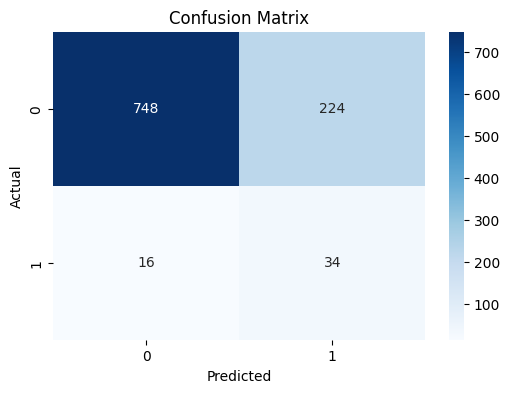

In [6]:
# plotting the performance metrics
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



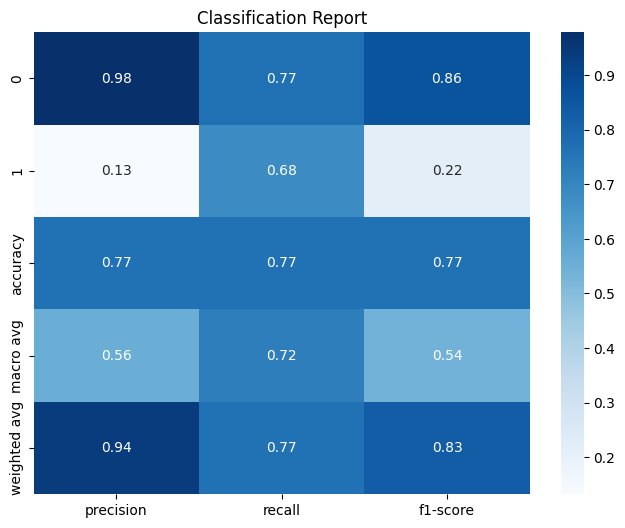

In [7]:
# plot classfication report
report = classification_report(y_test, y_pred, output_dict=True)
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()


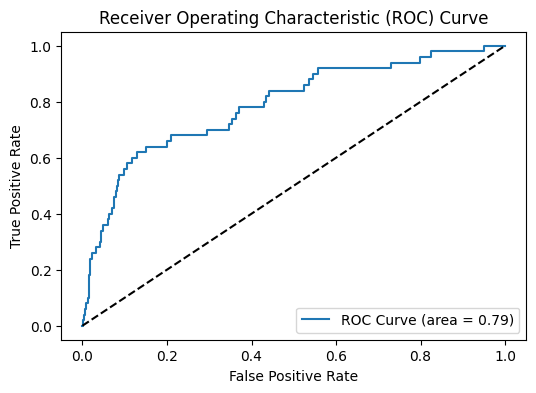

In [8]:
#line plot of roc curve
from pyexpat import model
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, model_pipeline.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, model_pipeline.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Using a sampling strategy of 1:1 between train and test data samples.**

Logistic regression does not seem powerful enough for this task. The low F1 score (18%) for predicitng strokes is low.

Precision score for 1 is 11%, meaning most predictive strokes are false positives.

**Tuning the minority upsampling does not improve the performance - the test set is small for the minority class (1).**

**It is better to try stronger classifier like Random Forest - which are known to handle small imbalanced datasets better**

In [9]:
#Reloading the cleaned data
df = pd. read_parquet('../Data/feature_engineered_stroke_data.parquet')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


Accuracy: 0.9478147423352903

Confusion Matrix:
 [[1451    7]
 [  73    2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.22      0.03      0.05        75

    accuracy                           0.95      1533
   macro avg       0.59      0.51      0.51      1533
weighted avg       0.92      0.95      0.93      1533


ROC AUC Score: 0.784951989026063


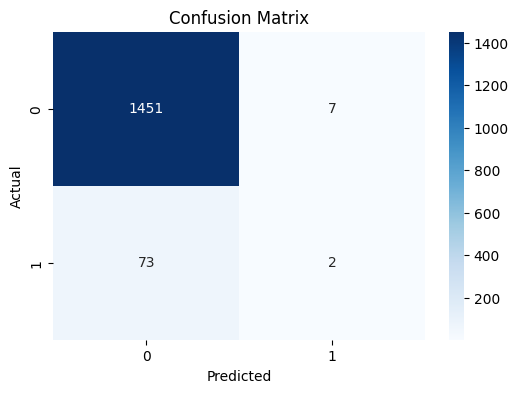

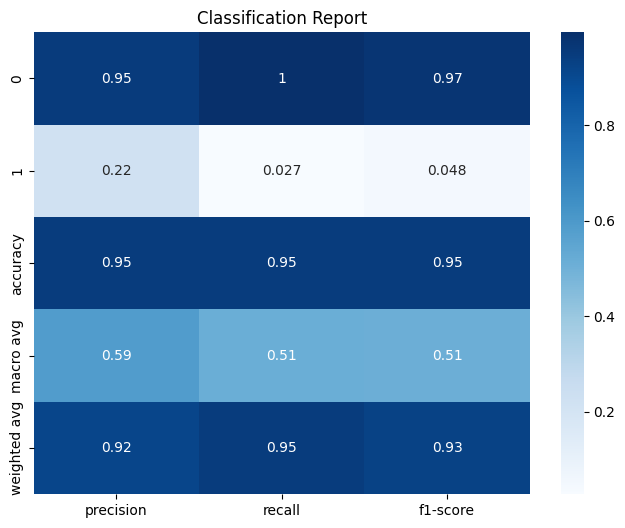

In [15]:
from sklearn.ensemble import RandomForestClassifier as RandomForest


#define features and targets and then train test split
X = df.drop(columns=['stroke'])
y = df['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
    )


# Identify columns
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns
categorical_cols = X_train.select_dtypes(include=['object','category']).columns

# Numerical pipeline (Median Impute)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])  
# Categorical pipeline (Most frequent or constant)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Full Pipeline with SMOTE + Random Forest
rf_pipeline = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42,sampling_strategy=0.5)),
    ('clf', RandomForest(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
        ))
])

# Fit the model on the training data
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred = rf_pipeline.predict(X_test)
y_pred_proba = rf_pipeline.predict_proba(X_test)[:,1]

# Applying predictions on test set
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# plotting the performance metrics
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')

plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# plot classfication report
report = classification_report(y_test, y_pred, output_dict=True)
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()


### Random Forest is performing better in overall accuracy compared to Logical regression

* However, it is stsill failing on the minority class.
* 50 samples in the minority class, so any small error drops recall and F1 massively.

* I will tune the Random Forest hyperparameters
* I will see if increeasing the test sample size helps or not

In [16]:
#Tuning the hyperparameters of Random Forest using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,                # 3-fold cross-validation
    n_jobs=-1,          # Use all available cores
    scoring='f1',       # Optimize for F1 score
    verbose=2          # Verbosity level
)

grid_search.fit(X_train, y_train)
# Evaluate the best model from grid search
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:,1]
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Accuracy: 0.9399869536855838

Confusion Matrix:
 [[1434   24]
 [  68    7]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      1458
           1       0.23      0.09      0.13        75

    accuracy                           0.94      1533
   macro avg       0.59      0.54      0.55      1533
weighted avg       0.92      0.94      0.93      1533


ROC AUC Score: 0.8014631915866484


In [17]:
#Finding an optimal threshold for classification

thresholds = [0.5, 0.3, 0.25, 0.2]

for thresh in thresholds:
    y_pred_adjusted = (y_pred_proba >= thresh).astype(int)
    print(f"\nThreshold = {thresh}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
    print(classification_report(y_test, y_pred_adjusted, digits=3))
    print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))


Threshold = 0.5
Confusion Matrix:
 [[1434   24]
 [  68    7]]
              precision    recall  f1-score   support

           0      0.955     0.984     0.969      1458
           1      0.226     0.093     0.132        75

    accuracy                          0.940      1533
   macro avg      0.590     0.538     0.550      1533
weighted avg      0.919     0.940     0.928      1533

ROC AUC: 0.8014631915866484

Threshold = 0.3
Confusion Matrix:
 [[1280  178]
 [  43   32]]
              precision    recall  f1-score   support

           0      0.967     0.878     0.921      1458
           1      0.152     0.427     0.225        75

    accuracy                          0.856      1533
   macro avg      0.560     0.652     0.573      1533
weighted avg      0.928     0.856     0.886      1533

ROC AUC: 0.8014631915866484

Threshold = 0.25
Confusion Matrix:
 [[1203  255]
 [  31   44]]
              precision    recall  f1-score   support

           0      0.975     0.825     0.894  